### 1. Data Loading and Initial Exploration

This section establishes a connection to the PostgreSQL database, retrieves the `fct_panel_evaluations_unpivoted` table, and loads the data into a Pandas DataFrame. Following the data loading, initial data exploration steps are performed to understand the structure, data types, summary statistics, and identify any missing values. This ensures data quality and readiness for further analysis.

In [14]:
import pandas as pd
from sqlalchemy import create_engine

# --- Database Connection Details ---
DB_NAME = "mochi_data"      
DB_USER = "postgres"         
DB_PASSWORD = "97653441" 
DB_HOST = "localhost"        
DB_PORT = "5432"  

# --- 1. Create a SQLAlchemy Engine ---
try:
    engine = create_engine(f'postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')
    print("SQLAlchemy engine created successfully.")
except Exception as e:
    print(f"Error creating SQLAlchemy engine: {e}")
    exit()

# --- 2. Define the SQL query ---
SQL_QUERY = "SELECT * FROM dbt_mochi.fct_panel_evaluations_unpivoted;"

# --- 3. Load Data into a Pandas DataFrame ---
try:
    df_mochi = pd.read_sql_query(SQL_QUERY, engine)
    print("Data loaded into Pandas DataFrame successfully!")
    print("DataFrame head:")
    print(df_mochi.head())
    print("\nDataFrame info:")
    df_mochi.info()

except Exception as e:
    print(f"Error executing query or loading data: {e}")
finally:
    # --- 4. Close the connection ---
    engine.dispose()
    print("SQLAlchemy engine disposed.")

# --- 5. Save DataFrame to CSV ---
print(df_mochi.head())
print(df_mochi.info())
print(df_mochi.describe())
print(df_mochi.isnull().sum())

SQLAlchemy engine created successfully.
Data loaded into Pandas DataFrame successfully!
DataFrame head:
    submission_id formulation  bitterness_score  sweetness_score  \
0  20250312125039           1                 6                1   
1  20250312125007           1                 4                2   
2  20250312130444           1                 6                1   
3  20250312130519           1                 5                2   
4  20250312130629           1                 5                2   

   chamomile_flavour_score  honey_flavour_score  creaminess_score  \
0                        4                    1                 2   
1                        3                    2                 2   
2                        4                    1                 2   
3                        4                    1                 3   
4                        2                    1                 2   

   overall_acceptability_score  
0                            2  
1     

### 2. Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a dimensionality reduction technique used here to transform the original sensory attribute scores into a new set of uncorrelated variables called principal components. This helps in identifying the most significant dimensions of variation within the mochi sensory data.

**Key Steps:**
* **Data Scaling:** Sensory scores are standardized (scaled to have zero mean and unit variance) to ensure that all attributes contribute equally to the PCA, regardless of their original measurement scales.
* **Scree Plot:** This plot helps determine the optimal number of principal components to retain by visualizing the explained variance ratio for each component. An "elbow" in the plot often indicates where adding more components provides diminishing returns.
* **PCA Model Fitting:** A PCA model is fitted to the scaled data to extract the principal components.
* **Feature Loadings:** The loadings represent the correlation of each original sensory attribute with the principal components. They indicate how much each original feature contributes to each principal component, aiding in their interpretation.


Scaled Data Head:
   bitterness_score  sweetness_score  chamomile_flavour_score  \
0          1.380862        -1.822181                 0.853484   
1          0.092057        -0.776667                -0.153435   
2          1.380862        -1.822181                 0.853484   
3          0.736460        -0.776667                 0.853484   
4          0.736460        -0.776667                -1.160355   

   honey_flavour_score  creaminess_score  
0            -1.392517         -1.425422  
1            -0.506370         -1.425422  
2            -1.392517         -1.425422  
3            -1.392517         -0.208598  
4            -1.392517         -1.425422  


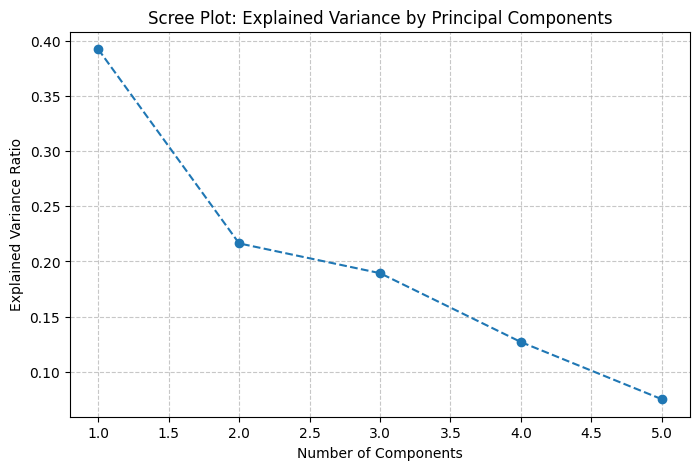


PCA DataFrame Head:
        PC1       PC2       PC3 formulation   submission_id  \
0 -2.895995  1.094902 -0.509695           1  20250312125039   
1 -1.028947  0.387438 -1.256816           1  20250312125007   
2 -2.895995  1.094902 -0.509695           1  20250312130444   
3 -1.738165  0.480678  0.420628           1  20250312130519   
4 -1.816304 -0.517543 -1.619231           1  20250312130629   

   overall_acceptability_score  
0                            2  
1                            3  
2                            3  
3                            3  
4                            3  

Explained variance ratio for each component:
[0.39248587 0.21634913 0.18932868]
Cumulative explained variance for 3 components: 79.82%

PCA Feature Loadings (Correlation Factor):
                              PC1       PC2       PC3
bitterness_score        -0.508706  0.195403  0.168483
sweetness_score          0.615054  0.112505  0.006105
chamomile_flavour_score -0.054042  0.796565  0.500213
honey_

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

sensory_columns = [
    'bitterness_score',
    'sweetness_score',
    'chamomile_flavor_score',
    'honey_flavor_score',
    'creaminess_score',
    'overall_acceptability_score' # For correlation analysis later
]

descriptive_sensory_columns = [
    'bitterness_score',
    'sweetness_score',
    'chamomile_flavour_score',
    'honey_flavour_score',
    'creaminess_score'
]

X = df_mochi[descriptive_sensory_columns].copy()

# Scaling the data
scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)

# Check scaled data
X_scaled_df = pd.DataFrame(X_scaled, columns=descriptive_sensory_columns, index=X.index)
print("\nScaled Data Head:")
print(X_scaled_df.head())

# Start with all components to evaluate explained variance
pca_full = PCA(n_components=len(descriptive_sensory_columns))
pca_full.fit(X_scaled)

# Explained variance ratio (scree plot)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(descriptive_sensory_columns) + 1), 
         pca_full.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot: Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Choose n_components ('2' for 2d and '3' for 3d)
n_components_chosen = 3 
pca = PCA(n_components=n_components_chosen)
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, 
                      columns=[f'PC{i+1}' for i in range(n_components_chosen)], 
                      index=X.index) # keep the index for merging

# Add excluded columns back into the original DataFrame
pca_df = pca_df.merge(df_mochi[['formulation', 'submission_id', 'overall_acceptability_score']],
                      left_index=True, right_index=True)

print("\nPCA DataFrame Head:")
print(pca_df.head())

# Check explained variance ratios for each component
print("\nExplained variance ratio for each component:")
print(pca.explained_variance_ratio_)
print(f"Cumulative explained variance for {n_components_chosen} components: {pca.explained_variance_ratio_.sum()*100:.2f}%")

# Interpretation of components (feature loadings)
loadings_df = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(n_components_chosen)], index=descriptive_sensory_columns)
print("\nPCA Feature Loadings (Correlation Factor):")
print(loadings_df)

### 3. Interactive 3D PCA Biplot

This interactive 3D biplot visualizes the mochi formulations in a reduced 3-dimensional space (PC1, PC2, PC3). Each point represents a mochi submission, colored by its `formulation`.

**Interpretation:**
* **Points:** Proximity of points indicates similar sensory profiles.
* **Arrows (Loadings):** The arrows represent the original sensory attributes. Their direction indicates the correlation of the attributes with the principal components. Longer arrows signify stronger contributions to the respective PCs. The angle between arrows indicates the correlation between the sensory attributes (small angle = high correlation, 90 degrees = no correlation, 180 degrees = negative correlation).
* **Overall:** This plot helps in understanding which formulations are similar or distinct, and which sensory attributes drive these separations in the 3D space.

In [16]:
import plotly.express as px
import plotly.graph_objects as go

# --- Define custom colors for your sensory characteristics ---
arrow_colors = [
    'blue',       # for 'bitterness_score'
    'red',        # for 'sweetness_score'
    'green',      # for 'chamomile_flavour_score'
    'orange',     # for 'honey_flavour_score'
    'purple'      # for 'creaminess_score'
]

if len(arrow_colors) != len(descriptive_sensory_columns):
    print("Warning: The number of arrow colors does not match the number of descriptive sensory columns. Falling back to default.")
    arrow_colors = px.colors.qualitative.Plotly[:len(descriptive_sensory_columns)]

# --- Generating the 3D Interactive Biplot with Simpler Arrowheads ---

# 1. Prepare the loadings for arrows
loadings_multiplier = 3.0 # <--- TUNE THIS VALUE! (e.g., 2, 3, 4, 5)
loadings = pca.components_.T # Raw loadings

# Create a list of traces for the arrow lines with markers as heads
arrow_traces = []
for i, feature_name in enumerate(descriptive_sensory_columns):
    # Calculate the scaled end point of the arrow
    end_x = loadings[i, 0] * loadings_multiplier
    end_y = loadings[i, 1] * loadings_multiplier
    end_z = loadings[i, 2] * loadings_multiplier

    current_arrow_color = arrow_colors[i]

    # Arrow line trace with a marker at the end
    arrow_trace = go.Scatter3d(
        x=[0, end_x],
        y=[0, end_y],
        z=[0, end_z],
        mode='lines+markers', # <--- KEY CHANGE: lines and markers
        line=dict(color=current_arrow_color, width=5),
        marker=dict(
            symbol='diamond', # <--- KEY CHANGE: Choose a marker symbol like 'triangle-up', 'triangle-down', 'triangle-left', 'triangle-right'
            size=5, # <--- TUNE THIS FOR MARKER SIZE
            color=current_arrow_color,
            # Adjust the `standoff` to prevent marker from overlapping the line end
            # This is experimental and might need tweaking for perfect alignment.
        ),
        name=f'{feature_name}',
        hoverinfo='text',
        hovertext=f'{feature_name}'
    )
    arrow_traces.append(arrow_trace)

# 2. Create the main scatter plot for data points, colored by 'formulation'
fig_data_points = px.scatter_3d(pca_df,
                                x='PC1', y='PC2', z='PC3',
                                color='formulation',
                                symbol='formulation',
                                hover_name='formulation',
                                hover_data={
                                    'PC1': ':.2f', 'PC2': ':.2f', 'PC3': ':.2f',
                                    'overall_acceptability_score': True,
                                    'formulation': False
                                },
                                title=f'Interactive 3D PCA Biplot with Formulations (Expl. Var: {pca.explained_variance_ratio_.sum()*100:.2f}%)',
                                labels={
                                    'PC1': f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)',
                                    'PC2': f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)',
                                    'PC3': f'PC3 ({pca.explained_variance_ratio_[2]*100:.2f}%)'
                                },
                                height=700
                               )

# --- ADD THIS SECTION TO MAKE SCATTER POINTS SMALLER ---
for trace in fig_data_points.data:
    if hasattr(trace, 'marker'): # Ensure the trace has marker properties
        trace.marker.size = 5 
                               
data_points_traces = fig_data_points.data

# 3. Combine all data point traces and arrow traces into a single go.Figure
fig_3d_biplot = go.Figure(data=list(data_points_traces) + arrow_traces)

# 4. Update the layout for the combined figure
fig_3d_biplot.update_layout(
    title=f'Interactive 3D PCA Biplot with Formulations (Expl. Var: {pca.explained_variance_ratio_.sum()*100:.2f}%)',
    scene=dict(
        xaxis_title=f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)',
        yaxis_title=f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)',
        zaxis_title=f'PC3 ({pca.explained_variance_ratio_[2]*100:.2f}%)',
        xaxis=dict(showgrid=True, zeroline=True),
        yaxis=dict(showgrid=True, zeroline=True),
        zaxis=dict(showgrid=True, zeroline=True),
    ),
    height=700
)

fig_3d_biplot.show()

### 4. 2D PCA Biplots by Formulation

These 2D PCA biplots provide a simpler, static view of the data, focusing on pairs of principal components (PC1 vs PC2, PC1 vs PC3, PC2 vs PC3). The points are colored by `formulation`, allowing for visual comparison of different mochi types based on their sensory profiles. The loading vectors (arrows) are also displayed, showing the influence of each original sensory attribute on the components.

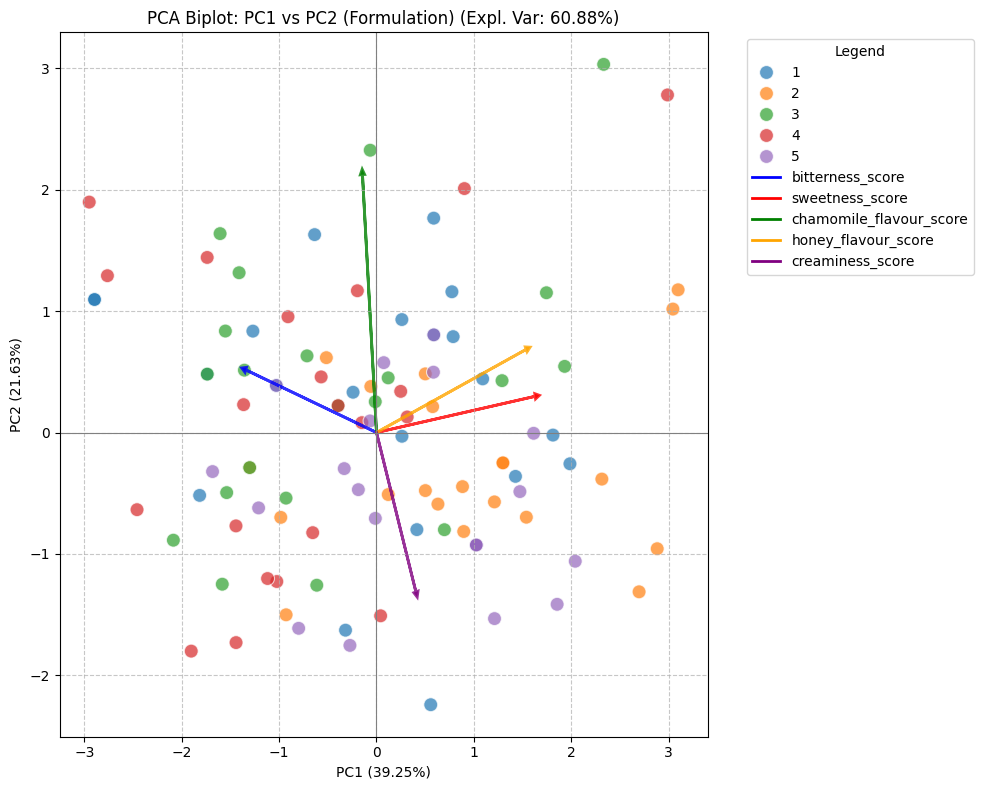

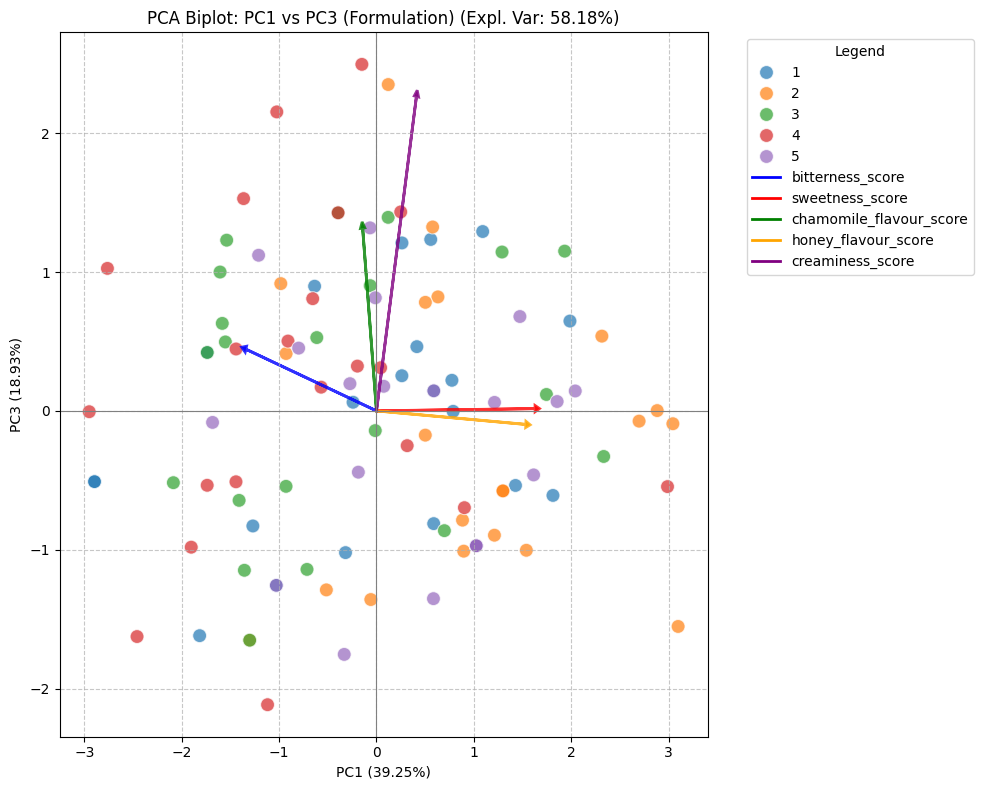

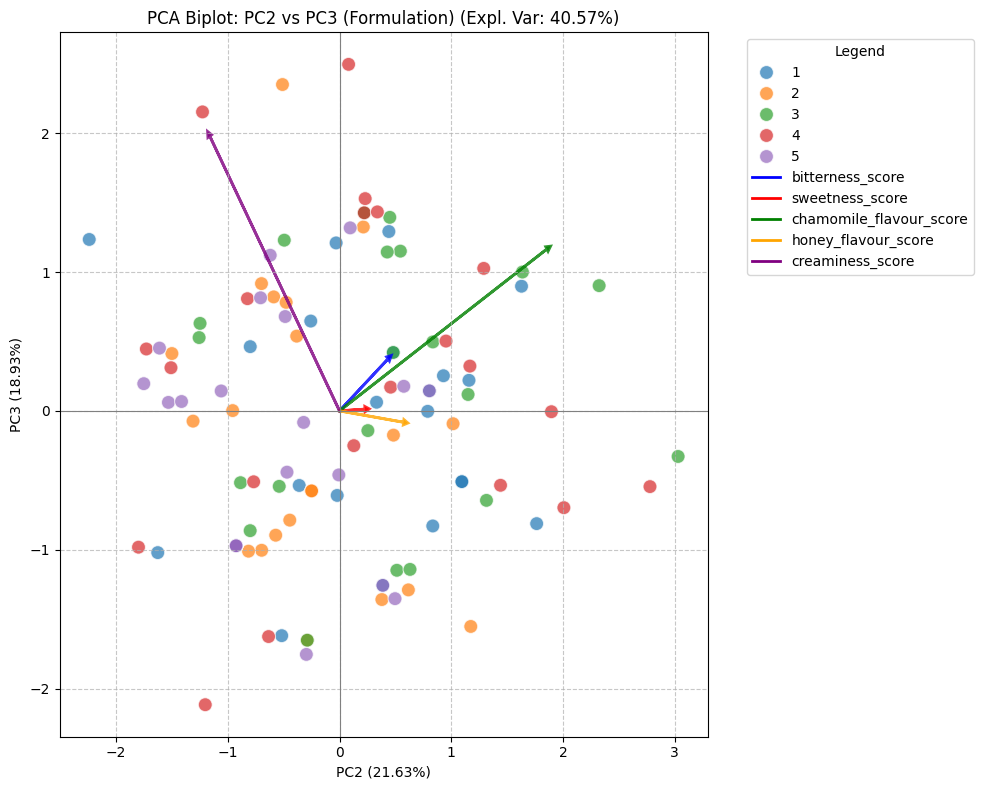

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines 

# --- Function to Generate a 2D Biplot ---
def plot_pca_biplot_2d(pca_df, pca_model, components, descriptive_features, hue_column='formulation', title_suffix=''):
    pc1_idx, pc2_idx = components
    pc1_name = f'PC{pc1_idx + 1}'
    pc2_name = f'PC{pc2_idx + 1}'

    # Get explained variance for the chosen components
    explained_variance_pc1 = pca_model.explained_variance_ratio_[pc1_idx]
    explained_variance_pc2 = pca_model.explained_variance_ratio_[pc2_idx]
    total_explained_variance = explained_variance_pc1 + explained_variance_pc2

    plt.figure(figsize=(10, 8))

    # Scatter plot of the data points
    scatter = sns.scatterplot(x=pc1_name, y=pc2_name, hue=hue_column, data=pca_df, # Store the scatter plot
                             s=100, alpha=0.7, palette='tab10', legend='full')

    # Plotting the loading vectors (arrows)
    loadings = pca_model.components_.T
    x_range = pca_df[pc1_name].max() - pca_df[pc1_name].min()
    y_range = pca_df[pc2_name].max() - pca_df[pc2_name].min()
    arrow_scale_factor = max(x_range, y_range) * 0.15

    # --- Define specific colors for each sensory feature ---
    arrow_colors_2d = [
        'blue',       # for 'bitterness_score'
        'red',        # for 'sweetness_score'
        'green',      # for 'chamomile_flavour_score'
        'orange',     # for 'honey_flavour_score'
        'purple'      # for 'creaminess_score'
    ]
    
    if len(descriptive_features) > len(arrow_colors_2d):
        print("Warning: Not enough unique colors for all features. Colors will repeat.")
        arrow_colors_2d = (arrow_colors_2d * ((len(descriptive_features) // len(arrow_colors_2d)) + 1))[:len(descriptive_features)]

    for i, feature in enumerate(descriptive_features):
        current_arrow_color = arrow_colors_2d[i]
        plt.arrow(0, 0,
                  loadings[i, pc1_idx] * (arrow_scale_factor * 3),
                  loadings[i, pc2_idx] * (arrow_scale_factor * 3),
                  color=current_arrow_color,
                  alpha=0.8, lw=2,
                  head_width=0.05 * arrow_scale_factor,
                  head_length=0.05 * arrow_scale_factor,
                  length_includes_head=True)

    plt.title(f'PCA Biplot: {pc1_name} vs {pc2_name} {title_suffix} (Expl. Var: {total_explained_variance*100:.2f}%)')
    plt.xlabel(f'{pc1_name} ({explained_variance_pc1*100:.2f}%)')
    plt.ylabel(f'{pc2_name} ({explained_variance_pc2*100:.2f}%)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axhline(0, color='grey', linewidth=0.8)
    plt.axvline(0, color='grey', linewidth=0.8)

    # --- Create combined legend ---
    handles, labels = scatter.get_legend_handles_labels()  # Get handles and labels from scatter

    # Create proxy artists for arrows
    arrow_handles = [mlines.Line2D([0], [0], color=arrow_colors_2d[i], lw=2, label=descriptive_features[i])
                     for i in range(len(descriptive_features))]

    handles.extend(arrow_handles)  # Add arrow handles
    labels.extend(descriptive_features)  # Add arrow labels

    plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left') # Create the combined legend

    plt.tight_layout()
    plt.show()

# --- Generate the 2D Biplots ---
# Plot 1: PC1 vs PC2 (colored by Fomulation)
plot_pca_biplot_2d(pca_df, pca, (0, 1), descriptive_sensory_columns,
                  hue_column='formulation',
                  title_suffix='(Formulation)')

# Plot 2: PC1 vs PC3 (colored by Fomulation)
plot_pca_biplot_2d(pca_df, pca, (0, 2), descriptive_sensory_columns,
                  hue_column='formulation',
                  title_suffix='(Formulation)')

# Plot 3: PC2 vs PC3 (colored by Fomulation)
plot_pca_biplot_2d(pca_df, pca, (1, 2), descriptive_sensory_columns,
                  hue_column='formulation',
                  title_suffix='(Formulation)')

# --- Optional: Plotting with Clusters as Hue ---
if 'cluster' in pca_df.columns:
    print("\n--- Plotting 2D Biplots with Clusters as Hue ---")
    plot_pca_biplot_2d(pca_df, pca, (0, 1), descriptive_sensory_columns,
                      hue_column='cluster',
                      title_suffix='(Cluster)')
    plot_pca_biplot_2d(pca_df, pca, (0, 2), descriptive_sensory_columns,
                      hue_column='cluster',
                      title_suffix='(Cluster)')
    plot_pca_biplot_2d(pca_df, pca, (1, 2), descriptive_sensory_columns,
                      hue_column='cluster',
                      title_suffix='(Cluster)')


### 5. K-Means Clustering for Segmentation

K-Means clustering is applied to the principal components (PC1, PC2, PC3) to group mochi formulations into distinct segments based on their sensory similarities.

**Key Steps:**
* **Elbow Method:** This method is used to determine the optimal number of clusters (K) by plotting the Within-Cluster Sum of Squares (WCSS) against the number of clusters. The "elbow point" where the rate of decrease in WCSS significantly slows down suggests an appropriate K.
* **K-Means Application:** Once an optimal K is chosen (in this case, `optimal_k = 10` was selected based on the Elbow plot), the K-Means algorithm assigns each mochi submission to a cluster. The cluster labels are then added back to the `pca_df` for further analysis and visualization.

Best K value is


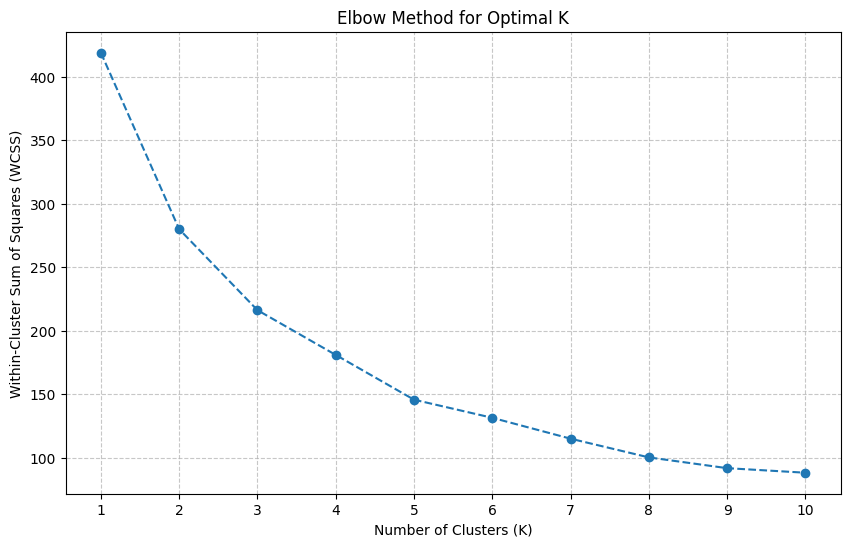

In [18]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import warnings

# Suppress the KMeans n_init warning (it defaults to 'auto' in newer versions)
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.cluster._kmeans")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")

# Extract these for clustering.
X_pca_for_clustering = pca_df[['PC1', 'PC2', 'PC3']].values

# Define a range of K values to test
k_values = range(1, 11) 

wcss = [] # List to store the Within-Cluster Sum of Squares

print("Best K value is")
for k in k_values:
    # Initialize KMeans with the current k
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_pca_for_clustering)
    wcss.append(kmeans.inertia_) # kmeans.inertia_ is the WCSS

# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_values) # Ensure x-axis ticks are integer k values
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [19]:
# Extract the PCA components for clustering
# Make sure these columns exist in your actual pca_df
X_pca_for_clustering = pca_df[['PC1', 'PC2', 'PC3']].values

# Choose the optimal number of clusters (K)
optimal_k = 10 # Based on your Elbow Method analysis

# Initialize and fit KMeans
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans_model.fit(X_pca_for_clustering)

# Add the cluster labels to your pca_df DataFrame
pca_df['cluster'] = kmeans_model.labels_

print(f"K-Means clustering with K={optimal_k} applied successfully!")
print("First 5 rows of pca_df with new 'cluster' column:")
print(pca_df.head())

K-Means clustering with K=10 applied successfully!
First 5 rows of pca_df with new 'cluster' column:
        PC1       PC2       PC3 formulation   submission_id  \
0 -2.895995  1.094902 -0.509695           1  20250312125039   
1 -1.028947  0.387438 -1.256816           1  20250312125007   
2 -2.895995  1.094902 -0.509695           1  20250312130444   
3 -1.738165  0.480678  0.420628           1  20250312130519   
4 -1.816304 -0.517543 -1.619231           1  20250312130629   

   overall_acceptability_score  cluster  
0                            2        7  
1                            3        1  
2                            3        7  
3                            3        7  
4                            3        3  


### 6. 2D PCA Biplots with Clusters and Acceptability

These biplots extend the 2D visualization by using the newly assigned `cluster` labels as the `hue` (color) for the data points, and `overall_acceptability_score` as the `size` of the points.

**Interpretation:**
* **Clusters:** Points of the same color belong to the same cluster, indicating shared sensory characteristics.
* **Point Size:** Larger points represent mochi formulations with higher overall acceptability scores. This helps to identify not only sensory segments but also which segments contain more highly-rated formulations.
* **Arrows:** The sensory attribute loading vectors remain, allowing for an understanding of the sensory drivers behind each cluster's position in the PCA space.


--- Plotting 2D Biplots with Clusters (Hue) and Acceptability (Size) ---


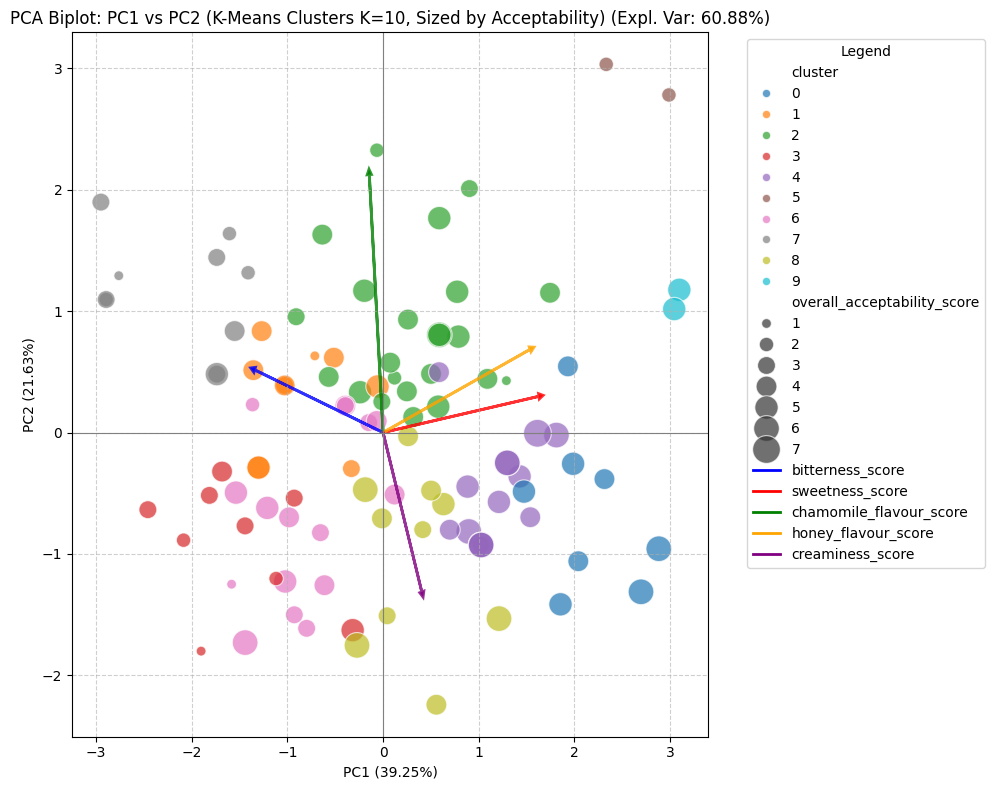

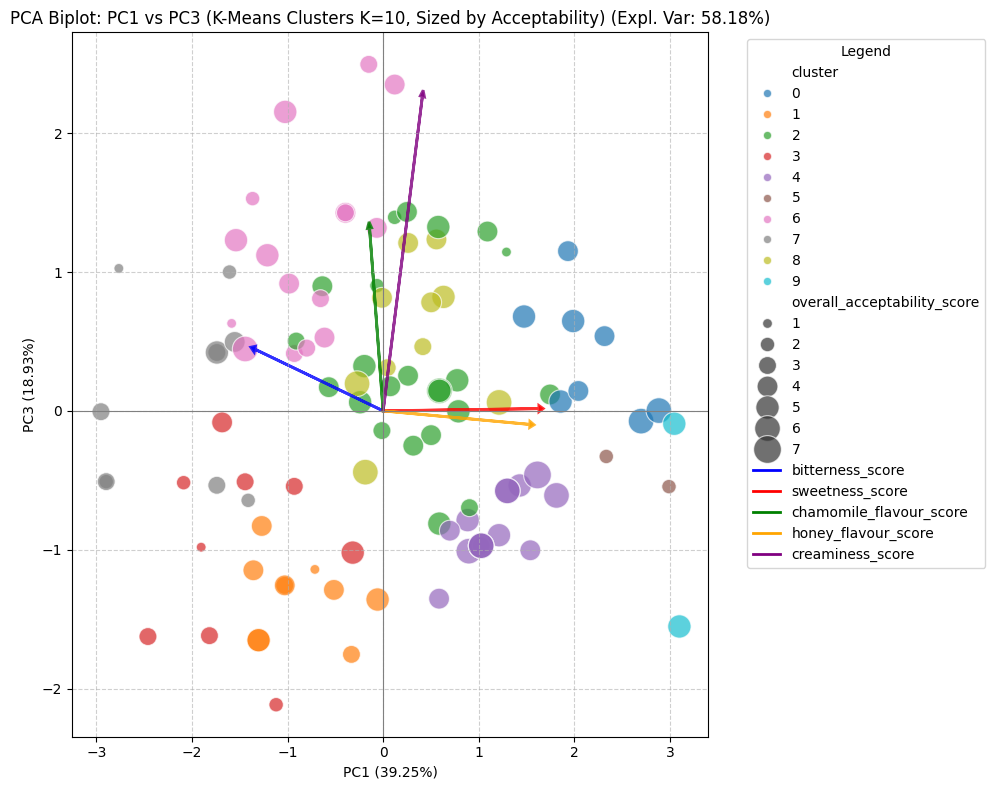

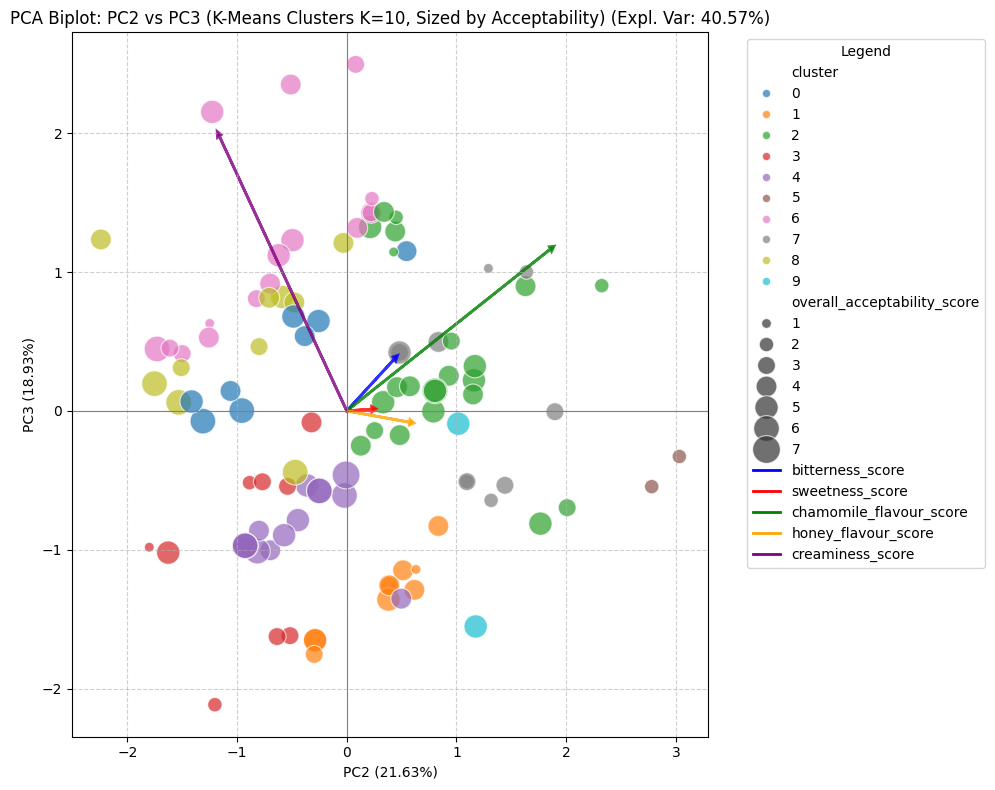

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# --- Function to Generate a 2D Biplot ---
def plot_pca_biplot_2d(pca_df, pca_model, components, descriptive_features,
                       hue_column='formulation', size_column=None, title_suffix=''):
    pc1_idx, pc2_idx = components
    pc1_name = f'PC{pc1_idx + 1}'
    pc2_name = f'PC{pc2_idx + 1}'

    explained_variance_pc1 = pca_model.explained_variance_ratio_[pc1_idx]
    explained_variance_pc2 = pca_model.explained_variance_ratio_[pc2_idx]
    total_explained_variance = explained_variance_pc1 + explained_variance_pc2

    plt.figure(figsize=(10, 8))

    # --- Add size based on size_column if provided ---
    scatter_kws = {'s': 100} # Default size if no size_column
    if size_column:
        # Define a range for marker sizes.
        scatter = sns.scatterplot(x=pc1_name, y=pc2_name, hue=hue_column, data=pca_df,
                                  size=size_column, sizes=(50, 400),
                                  alpha=0.7, palette='tab10', legend='full')
    else:
        scatter = sns.scatterplot(x=pc1_name, y=pc2_name, hue=hue_column, data=pca_df,
                                  s=100, alpha=0.7, palette='tab10', legend='full')

    loadings = pca_model.components_.T
    x_range = pca_df[pc1_name].max() - pca_df[pc1_name].min()
    y_range = pca_df[pc2_name].max() - pca_df[pc2_name].min()
    arrow_scale_factor = max(x_range, y_range) * 0.15

    arrow_colors_2d = [
        'blue',     # bitterness_score
        'red',      # sweetness_score
        'green',    # chamomile_flavour_score
        'orange',   # honey_flavour_score
        'purple'    # creaminess_score
    ]
    if len(descriptive_features) > len(arrow_colors_2d):
        print("Warning: Not enough unique colors for all features. Colors will repeat.")
        arrow_colors_2d = (arrow_colors_2d * ((len(descriptive_features) // len(arrow_colors_2d)) + 1))[:len(descriptive_features)]

    for i, feature in enumerate(descriptive_features):
        current_arrow_color = arrow_colors_2d[i]
        plt.arrow(0, 0,
                  loadings[i, pc1_idx] * (arrow_scale_factor * 3),
                  loadings[i, pc2_idx] * (arrow_scale_factor * 3),
                  color=current_arrow_color,
                  alpha=0.8, lw=2,
                  head_width=0.05 * arrow_scale_factor,
                  head_length=0.05 * arrow_scale_factor,
                  length_includes_head=True)

    plt.title(f'PCA Biplot: {pc1_name} vs {pc2_name} {title_suffix} (Expl. Var: {total_explained_variance*100:.2f}%)')
    plt.xlabel(f'{pc1_name} ({explained_variance_pc1*100:.2f}%)')
    plt.ylabel(f'{pc2_name} ({explained_variance_pc2*100:.2f}%)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axhline(0, color='grey', linewidth=0.8)
    plt.axvline(0, color='grey', linewidth=0.8)

    # --- Create combined legend ---
    handles, labels = scatter.get_legend_handles_labels()
    arrow_handles = [mlines.Line2D([0], [0], color=arrow_colors_2d[i], lw=2, label=descriptive_features[i])
                     for i in range(len(descriptive_features))]
    
    # Add the arrow handles to the legend
    handles.extend(arrow_handles)
    labels.extend(descriptive_features)
    plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# --- Call the function to plot with acceptability score as size ---
print("\n--- Plotting 2D Biplots with Clusters (Hue) and Acceptability (Size) ---")

# Plotting PC1 vs PC2, colored by cluster, sized by overall_acceptability_score
plot_pca_biplot_2d(pca_df, pca, (0, 1), descriptive_sensory_columns,
                   hue_column='cluster', # Color by cluster
                   size_column='overall_acceptability_score', # Size by acceptability
                   title_suffix=f'(K-Means Clusters K={optimal_k}, Sized by Acceptability)')

plot_pca_biplot_2d(pca_df, pca, (0, 2), descriptive_sensory_columns,
                   hue_column='cluster',
                   size_column='overall_acceptability_score',
                   title_suffix=f'(K-Means Clusters K={optimal_k}, Sized by Acceptability)')

plot_pca_biplot_2d(pca_df, pca, (1, 2), descriptive_sensory_columns,
                   hue_column='cluster',
                   size_column='overall_acceptability_score',
                   title_suffix=f'(K-Means Clusters K={optimal_k}, Sized by Acceptability)')

### 7. Cluster Analysis and Best Formulation Identification

This section provides a deeper dive into the characteristics of the identified clusters, focusing on their overall acceptability.

**Analysis Steps:**
* **Acceptability Distribution (Box Plot):** A box plot visualizes the distribution of `overall_acceptability_score` for each cluster, highlighting differences in perceived quality across segments.
* **Detailed Statistics:** Descriptive statistics (mean, median, standard deviation, etc.) for `overall_acceptability_score` are calculated for each cluster, offering a quantitative summary of their acceptability.
* **Best Cluster Identification:** The cluster with the highest average `overall_acceptability_score` is identified as the "best performing cluster."
* **Formulation-Level Analysis:** Within the best-performing cluster, average acceptability scores for individual formulations are calculated, and the most frequent (mode) formulations are identified. This helps pinpoint specific mochi recipes that resonate well with consumers and are representative of a highly-accepted sensory profile.

C:\Users\amiru\AppData\Local\Temp\ipykernel_3000\1287603796.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




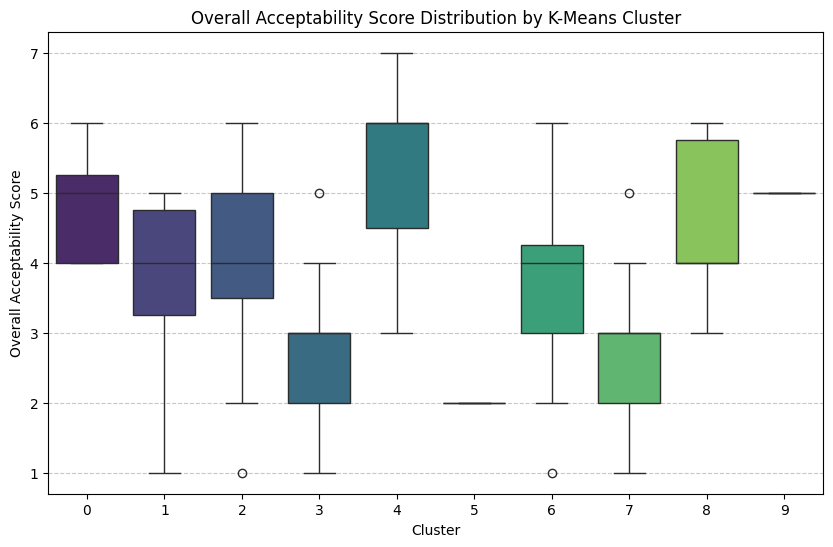


--- Detailed Acceptability Statistics per Cluster ---
         count      mean       std  min   25%  50%   75%  max
cluster                                                      
0          8.0  4.875000  0.834523  4.0  4.00  5.0  5.25  6.0
1         10.0  3.800000  1.229273  1.0  3.25  4.0  4.75  5.0
2         23.0  3.956522  1.186219  1.0  3.50  4.0  5.00  6.0
3          9.0  2.888889  1.166667  1.0  2.00  3.0  3.00  5.0
4         15.0  5.266667  1.099784  3.0  4.50  6.0  6.00  7.0
5          2.0  2.000000  0.000000  2.0  2.00  2.0  2.00  2.0
6         16.0  3.687500  1.250000  1.0  3.00  4.0  4.25  6.0
7         10.0  2.800000  1.135292  1.0  2.00  3.0  3.00  5.0
8         10.0  4.500000  1.178511  3.0  4.00  4.0  5.75  6.0
9          2.0  5.000000  0.000000  5.0  5.00  5.0  5.00  5.0

--- Identifying Best Performing Cluster (by Mean Acceptability) ---
The best performing cluster is Cluster 4 with an average acceptability of 5.27.

--- Average Acceptability Score for Each Unique For

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Start of the Box Plot Code ---
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='overall_acceptability_score', data=pca_df, palette='viridis')
plt.title('Overall Acceptability Score Distribution by K-Means Cluster')
plt.xlabel('Cluster')
plt.ylabel('Overall Acceptability Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Code to Get Detailed Acceptability Statistics per Cluster ---
# Calculate descriptive statistics for 'overall_acceptability_score' for each cluster
cluster_acceptability_stats = pca_df.groupby('cluster')['overall_acceptability_score'].describe()

print("\n--- Detailed Acceptability Statistics per Cluster ---")
# Using .to_string() for better formatting in console output
print(cluster_acceptability_stats.to_string())


# --- Code to Identify Best Formulations (based on mean acceptability from the stats table) ---
# Step 1: Identify the best performing cluster based on its mean acceptability
best_cluster_id = cluster_acceptability_stats['mean'].idxmax()
best_cluster_avg_score = cluster_acceptability_stats.loc[best_cluster_id, 'mean']


print(f"\n--- Identifying Best Performing Cluster (by Mean Acceptability) ---")
print(f"The best performing cluster is Cluster {best_cluster_id} with an average acceptability of {best_cluster_avg_score:.2f}.")

# Step 3: Filter for formulations in the best cluster
if 'formulation' in pca_df.columns:
    # Get all data points belonging to the best cluster
    best_cluster_data_points = pca_df[pca_df['cluster'] == best_cluster_id]

    # --- Calculate average acceptability per unique formulation within this cluster ---
    if not best_cluster_data_points.empty:
        average_acceptability_by_formulation = best_cluster_data_points.groupby('formulation')['overall_acceptability_score'].mean().sort_values(ascending=False)

        print(f"\n--- Average Acceptability Score for Each Unique Formulation in Cluster {best_cluster_id} ---")
        print(average_acceptability_by_formulation.to_string())

        # --- Identify the Most Frequent Formulation (Mode) in the Best Cluster ---
        print(f"\n--- Most Frequent Formulation(s) (Mode) in Cluster {best_cluster_id} ---")
        most_frequent_formulations_in_best_cluster = best_cluster_data_points['formulation'].mode()

        if not most_frequent_formulations_in_best_cluster.empty:
            if len(most_frequent_formulations_in_best_cluster) == 1:
                print(f"The formulation appearing most often (mode) in Cluster {best_cluster_id} is: {most_frequent_formulations_in_best_cluster.iloc[0]}")
            else:
                print(f"Multiple formulations tie for the most frequent (mode) in Cluster {best_cluster_id}:")
                for f in most_frequent_formulations_in_best_cluster.tolist():
                    print(f"- {f}")
        else:
            print(f"Could not determine mode for Cluster {best_cluster_id} (e.g., 'formulation' column might be empty for these rows).")

    else:
        print(f"\nCluster {best_cluster_id} is empty. No formulations found to analyze.")

else:
    print("\n'formulation' column not found in pca_df. Cannot list specific formulations or calculate mode.")
    print("Please ensure your pca_df includes a 'formulation' column with your product names.")

### 8. Exporting Clustered Data

The final `pca_df` DataFrame, which now includes the assigned `cluster` labels, is exported to a CSV file. This allows for easy access to the processed data for further analysis, reporting, or integration with other tools.

In [22]:
# --- Export the final DataFrame with cluster assignments to CSV ---
output_csv_path = 'mochi_pca_clustered_data.csv'
pca_df.to_csv(output_csv_path, index=False) # index=False prevents writing the DataFrame index as a column
print(f"\nDataFrame with PCA components and cluster assignments exported to: {output_csv_path}")


DataFrame with PCA components and cluster assignments exported to: mochi_pca_clustered_data.csv
